In [1]:
from sympy.physics.optics import RayTransferMatrix, ThinLens, BeamParameter, FreeSpace
from sympy import symbols, init_printing, pi, sqrt, pprint, solveset, S, plot, cos, Eq
from scipy.constants import c
import matplotlib.pyplot as plt
import numpy as np

init_printing()

from ipywidgets.widgets import (
    IntSlider,
    FloatLogSlider,
    FloatSlider,
    interactive_output,
    FloatRangeSlider,
    BoundedFloatText,
    Checkbox,
    HBox,
    VBox,
    IntRangeSlider,
    BoundedIntText,
    Text,
    Button,
    Label,
    Select,
    Layout
)
from IPython.display import display
import datetime, os
from os.path import isdir

Confocal length: $Z_c$, 
Radius of the curvature of beam wave front: 
R(z) and the Beam radius: w(z) are defined such as: 



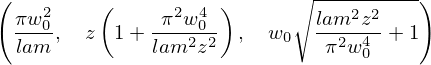

In [2]:
w, lam, w0, z = symbols("w, lam, w0, z", positive=True)

# defining the confocal length, R(z) and w(z) in sympy
z_r = pi * w0 ** 2 / lam
R = z * (1 + (z_r / z) ** 2)
w = w0 * sqrt(1 + (z / z_r) ** 2)

# Defining the z-propagation range
z_ = np.linspace(0, 20, 10)

# Defining functions
def ghz_cm(x):
    return c * 1e2 / x * 1e-9


print(\
    "Confocal length: $Z_c$, \
\nRadius of the curvature of beam wave front: \
\nR(z) and the Beam radius: w(z) are defined such as: \n"
)

z_r, R, w

In [3]:
class gaussian_simulation:
    def __init__(self):

        W = BoundedFloatText(value=0.34, min=0.1, max=1, step=0.01, description="w0:")
        L = IntRangeSlider(
            value=[325, 1100], min=100, max=1500, step=1, description="GHz"
        )

        width = BoundedIntText(value=16, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=11, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=120, min=70, max=250, step=1, description="Dpi")

        entry1 = BoundedFloatText(
            value=-8.4, min=-10, max=10, step=0.1, description="Entry1"
        )
        entry2 = BoundedFloatText(
            value=2, min=0, max=10, step=0.1, description="Entry2"
        )

        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        row1 = HBox([W, L])
        row2 = HBox([width, height, dpi])
        row3 = HBox([entry1, entry2])

        out = interactive_output(
            self.simulate,
            {
                "w0_": W,
                "wn": L,
                "width": width,
                "height": height,
                "dpi": dpi,
                "entry1": entry1,
                "entry2": entry2,
            },
        )

        display(
            VBox(
                [row1, row2, row3, out, self.save_name, save_button, self.print_save]
            )
        )

    def save_plot(self, event):
        if not isdir('./Simulations'):
            os.mkdir('./Simulations')

        self.fig0.savefig(f"./Simulations/{self.save_name.value}.png")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

    def beam_plot(self, ax, w0_, wn):

        self.gaussian_beam(w0_, wn)

        for c, beam in enumerate(self.beams):
            color = f"C{c}"
            ax.plot(
                z_,
                beam,
                f"--{color}",
                label=f"{self.wn[c]:.2f} GHz ({ghz_cm(self.wn[c])*10:.2f} mm)",
            )
            ax.plot(-z_, -beam, f"--{color}")
            ax.plot(-z_, beam, f"--{color}")
            ax.plot(z_, -beam, f"--{color}")

    def simulate(self, w0_, wn, width, height, dpi, entry1, entry2):

        self.fig0, ax0 = plt.subplots(figsize=(width, height), dpi=dpi)
        self.beam_plot(ax0, w0_, wn)

        ax0.hlines(0, xmin=-z_.max(), xmax=z_.max())

        ## Annotation begins

        # Distance b/w two entry points
        ax0.hlines(-0.2, xmin=entry1, xmax=entry2)
        plt.annotate(
            s=f"d={(entry2-entry1):.2f}",
            xy=(0, 0),
            xytext=(0, -0.3),
            ha="center",
            va="center",
        )

        # Annotate beam waist
        ax0.vlines(x=0, ymin=0, ymax=w0_)
        plt.annotate(
            s=f"w0={w0_} cm",
            xy=(0, w0_),
            xytext=(0, 0.7),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate Entry1
        ax0.vlines(x=entry1, ymin=-1, ymax=1)

        plt.annotate(
            s="Main entry window: diameter=2cm",
            xy=(entry1, 1),
            xytext=(entry1 + 5, 1.1),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate Entry2
        ax0.vlines(x=entry2, ymin=-0.43, ymax=0.43)

        plt.annotate(
            s="Trap bender entry: diameter=0.86cm",
            xy=(entry2, -0.43),
            xytext=(entry2 - 3, -0.8),
            ha="center",
            va="center",
            # rotation = 30,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate z-position

        plt.annotate(s="z=0", xy=(0, 0), xytext=(0, -0.05), ha="center", va="center")

        plt.annotate(
            s=f"z={entry2}",
            xy=(entry2, 0),
            xytext=(entry2 + 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        plt.annotate(
            s=f"z={entry1}",
            xy=(entry1, 0),
            xytext=(entry1 - 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        ## Annotation ends

        ax0.set_xlabel("z direction : Beam Propagation (cm)")
        ax0.set_ylabel("w(z) : Gaussian Beam radius (cm)")
        ax0.set_title(f"Gaussian Beam simulation: {wn[0]}-{wn[-1]} GHz")
        ax0.legend()
        plt.show()
        # plt.close()

        self.save_name.value = f"{w0_}cm-{wn[0]}-{wn[-1]}GHz_simulation"

    def gaussian_beam(self, w0_, wn):

        global w, z_

        self.wn = np.linspace(*wn, 10)

        beam = []
        beams = []

        for l in self.wn:

            temp = []
            beam = []

            for i in z_:
                temp = float(w.subs({w0: w0_, lam: ghz_cm(l), z: i}).evalf())
                beam.append(temp)
            beams.append(beam)

        self.beams = np.array(beams)

# Simulating Gaussian beam propagation from inside FELion Trap

We will try to obtain the optimum conditions such the waist radius w0 and distance to the w0 from outside mirror, etc.

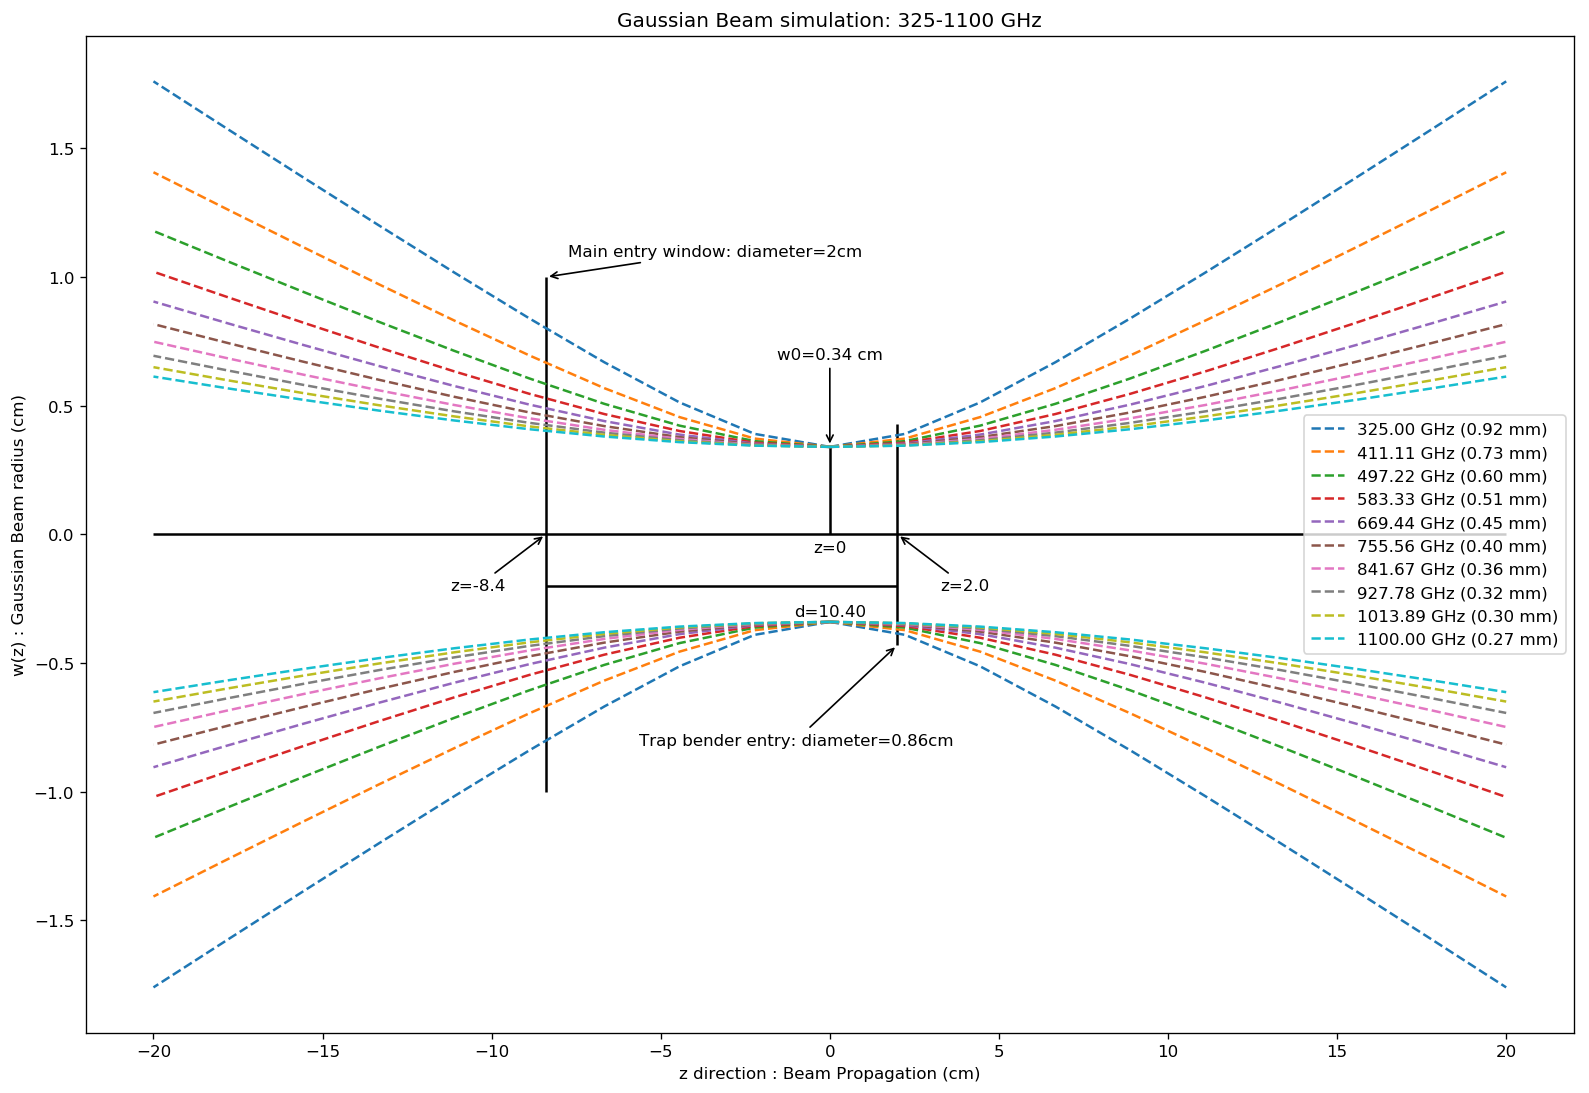

In [4]:
#%matplotlib widget
%matplotlib inline
start = gaussian_simulation()

# Ellipsoidal mirror (Goldsmith, 1998)

An ellipsoidal mirror in the geometrical optics limit, transforms radiation from a point source at one focal point to a point source located at the second focal point; this is true for any part of the ellipsoidal surface of revolution,
formed by rotating the ellipse about the line joining its foci. 

First consider a lens that has a focal length equal to the distance from the first focal point to the center of the part of the ellipsoidal surface being used (R1). 
This lens will collimate the radiation from the first focal point into a parallel beam. 

If we immediately follow this first lens by a second, having focal length equal to the distance from the center of the mirror to the second focal point (R2) , the second lens will bring the parallel beam to a focus at the desired position. 



## Thin lens
ABCD matrix for thin lens of focal length $f_{lens}$

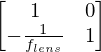

In [5]:
f_lens = symbols('f_lens')
M_lens = ThinLens(f_lens)
M_lens

## Elliptical mirror effective focal length

Thus, the ABCD matrix for an ellipsoidal mirror is the product of two matrices, each representing a thin lens, and having zero separation:
where R1 and R2 are the distances from the center of the section of the ellipsoid used to the respective foci

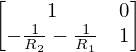

In [6]:
R1, R2 = symbols('R1, R2')
M_l1 = ThinLens(R1)
M_l2 = ThinLens(R2)
M_d = FreeSpace(0)
M_ellipsoid = M_l2*M_d*M_l1
M_ellipsoid

So that comparing with the expression for the thin lens, we see that the Effective focal length of an elliptical mirror: f_ellipsoid is given by

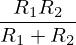

In [7]:
f_ellipsoid = 1/(1/R1+1/R2)
print('\n')
f_ellipsoid.simplify()

# Mode Matching (Goldsmith 1998)

Quasioptical system designers are often required to couple the power in a beam (e.g., that produced by a feed hom) to a specified beam waist radius (e.g., that required by some component in a receiver system). Dealing with beam transformation from this perspective is often called mode matching

## Case 1:
In practice most often the case is: We are given the input and output waist radii, and thus the magnification, together with the input distance. Solving for the required focal length, we obtain

In [8]:
M, E, d_in, d_out, w0_in, w0_out, Z_c = symbols('M, E, d_in, d_out, w0_in, w0_out, Z_c')

fp = Z_c*(d_in/(E*Z_c))*(1+sqrt(1-E*(1+(d_in/Z_c)**-2)))
fm = Z_c*(d_in/(E*Z_c))*(1-sqrt(1-E*(1+(d_in/Z_c)**-2)))

Positive and negative focus "f" for M>1

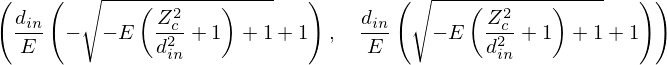

In [9]:
fm, fp

For M=1
Focus is given by:


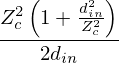

In [10]:
f1 = Z_c*(1+(d_in/Z_c)**2)/(2*d_in/Z_c)
print('For M=1\nFocus is given by:')
f1

Assuming for the case of our ellipse, 
$$d_{in} = R1$$  $$f = f_{ellipsoid}$$ 

we can solve for R2 i.e., $d_{out}$


The eccentricity can also be defined in terms of R1, R2, and the angle α between input and output beams (Goldsmith, 1998)

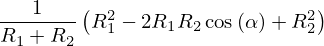

In [11]:
alpha = symbols('alpha')
e = (R1**2 + R2**2 - 2*R1*R2*cos(alpha))/(R1 + R2)
e

For our case, alpha = 90, we get eccentricity as: 



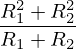

In [12]:
print('For our case, alpha = 90, we get eccentricity as: \n')
e_ellipsoid = e.subs({alpha:pi/2}).evalf()
e_ellipsoid

Eccentricity of an elliptical mirror is already defined as :



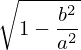

In [13]:
a, b = symbols('a, b')
print('Eccentricity of an elliptical mirror is already defined as :\n')

e_standard = sqrt(1-b**2/a**2)
e_standard

where a and b are the semi-major and semi-minor axis respectivey.

The semi-major axis a is also defined as: 



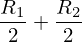

In [14]:
print('The semi-major axis a is also defined as: \n')
a = (R1 + R2)/2
a

In [15]:
class f_soln:
    def __init__(self):
        mag = BoundedFloatText(
            value=0.41, min=0.1, max=10, step=0.01, description="M: "
        )
        W = BoundedFloatText(
            value=0.34, min=0.1, max=1, step=0.01, description="w0_in: "
        )
        R1 = BoundedFloatText(value=18, min=5, max=20, step=0.1, description="R1: ")
        L = IntRangeSlider(
            value=[325, 500], min=50, max=1500, step=1, description="GHz"
        )

        width = BoundedIntText(value=10, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=6, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=100, min=70, max=250, step=1, description="Dpi")

        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        row1 = HBox([width, height, dpi])
        row2 = HBox([mag, W, R1, L])

        out = interactive_output(
            self.plot,
            {
                "M": mag,
                "r1": R1,
                "w0_in": W,
                "lam": L,
                "width": width,
                "height": height,
                "dpi": dpi,
            },
        )

        display(VBox([row1, row2, out, self.save_name, save_button, self.print_save]))

    def plot(self, M, r1, w0_in, lam, width, height, dpi):

        wn = np.linspace(*lam, 50)

        x, y1, y2 = [], [], []
        no_soln, soln = [], []
        for l in wn:
            zc = np.pi * w0_in ** 2 / ghz_cm(l)

            temp0 = r1 / zc
            x.append(temp0)

            try:

                if not M == 1:
                    temp1 = fm / zc
                    temp1_1 = float(
                        temp1.subs({E: 1 - M ** -2, d_in: r1, Z_c: zc}).evalf()
                    )
                elif M == 1:
                    temp1 = f1 / Zc
                    temp1_1 = float(temp1.subs({d_in: r1, Z_c: zc}).evalf())

                y1.append(temp1_1)
                soln.append(round(l, 2))
            except:
                no_soln.append(round(l, 2))

        self.fig, axs = plt.subplots(figsize=(width, height), dpi=dpi)

        x_ = x[: len(y1)]
        axs.plot(x_, y1, color='C0', label=f"f/$Z_c$; $w0(trap)$={w0_in}cm;" + "$d_{in}$=%.2f cm" % r1,)
        
        axs.legend()
        axs.grid()
        axs.set_xlabel("$d_{in}$/$Z_c$")
        axs.set_ylabel("f/$Z_c$", color='C0')
        axs.set_title(
            f"For M={M}: Solution exist for {soln[0]}-{soln[-1]} GHz"
        )
        axs.tick_params(axis='y', labelcolor='C0')
        
        
        if len(no_soln) > 0 and len(soln) > 0:
            print(f"\nSolution: Exists for {soln[0]}-{soln[-1]} GHz\n")

            print(f"Does not exist for: {no_soln[0]}-{no_soln[-1]} GHz\n")
        if len(soln) < 1:
            print(f"x: {x}\ny: {y1}")

        # Finding R2 position:
        x_ = np.array(x_)
        y1 = np.array(y1)
        r2 = r1 / ((x_ / y1) - 1)
        r2_ind = np.logical_and(r2 <= 50, r2 > 0)
        
        axs1 = axs.twinx()
        axs1.plot(x_[r2_ind], r2[r2_ind], color='C1', label="$d_{out}$")
        
        axs1.set_ylabel('$d_{out}$ (cm)', color='C1')
        axs1.tick_params(axis='y', labelcolor='C1')
        axs1.legend()
        
        #self.fig.legend()
        
        try:
            self.save_name.value = f"M-{M}_{soln[0]}-{soln[-1]}GHz_din_{r1}cm"
        except:
            pass
        plt.show()

    def save_plot(self, event):

        self.fig.savefig(f"./{self.save_name.value}.png")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

## Simulation to determine optimal focal length solution for elliptical mirror.

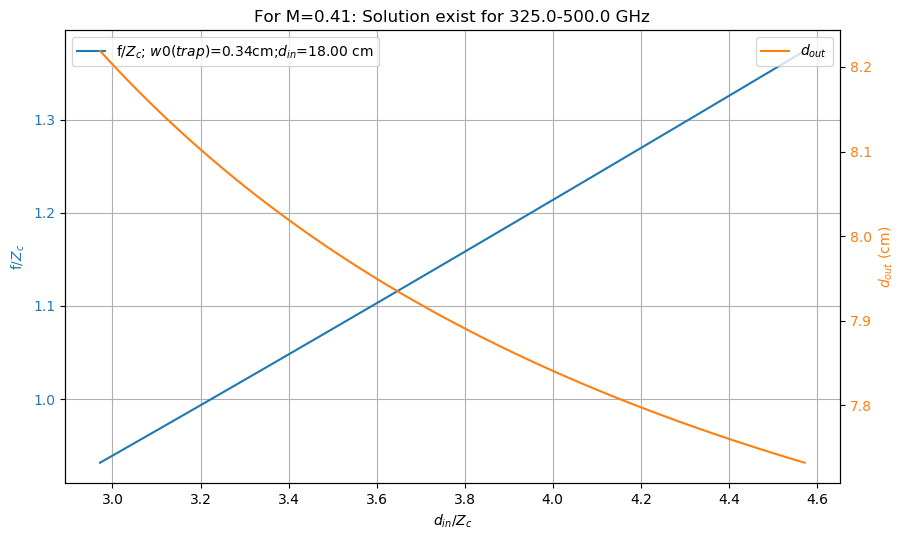

In [16]:
start = f_soln()

The above simulation shows that we might need different focal length R2 for different wavelength, so we cannot use this method. Let us examine another case as defined below.

## Case 2:

The input and output distance to waist is a fixed sum d, then the expression for input and output distance is given by:

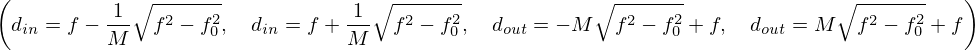

In [17]:
f, f0, d, M, d_in, d_out = symbols("f, f0, d, M, d_in, d_out")

eq_din_m = Eq(d_in, f - sqrt(f ** 2 - f0 ** 2) / M)
eq_din_p = Eq(d_in, f + sqrt(f ** 2 - f0 ** 2) / M)

eq_dout_m = Eq(d_out, f - sqrt(f ** 2 - f0 ** 2) * M)
eq_dout_p = Eq(d_out, f + sqrt(f ** 2 - f0 ** 2) * M)

radius = Eq(R)

eq_din_m, eq_din_p, eq_dout_m, eq_dout_p

We will now try to find the focal length for an optimal d_out corresponds to M (which provides w_out since we already know w_in) using the known set d_in value (from trap) and 
$$f0 = \pi*(w0_{in}*w0_{out})/\lambda$$

In [18]:
class f_case2:
    def __init__(self):
        Win = BoundedFloatText(
            value=0.34, min=0.1, max=1, step=0.01, description="$w0_{in}$: "
        )
        Wout = BoundedFloatText(
            value=0.15, min=0.01, max=1, step=0.01, description="$w0_{out}$: "
        )
        D1 = BoundedFloatText(
            value=18, min=5, max=20, step=0.1, description="$d_{in}$: "
        )
        L = IntRangeSlider(
            value=[325, 500], min=50, max=1500, step=1, description="GHz"
        )
        
        Lg_X = BoundedFloatText(
            value=1, min=0.1, max=2, step=0.1, description="lg_x"
        )
        
        Lg_Y = BoundedFloatText(
            value=0.9, min=0, max=2, step=0.1, description="lg_y"
        )
        
        Lg_X1 = BoundedFloatText(
            value=1, min=0.1, max=2, step=0.1, description="lg_x"
        )
        
        Lg_Y1 = BoundedFloatText(
            value=1, min=0, max=2, step=0.1, description="lg_y"
        )

        width = BoundedIntText(value=15, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=6, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=106, min=70, max=250, step=1, description="Dpi")

        Xlabel = Text(value="Frequency (GHz)")
        Ylabel_0 = Text(value=" + ve f (cm)")
        Ylabel_1 = Text(value=" - ve f (cm)")
        Title = Text(
            value="Determining focal length (f) from given M and $d_{in}$ then calculating $d_{out}$"
        )

        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        self.focal_list1 = Select(
            options=["1"],
            description="+ve F:",
            layout=Layout(width="30%", height="160px"),
        )

        self.focal_list2 = Select(
            options=["2"],
            description="-ve F:",
            layout=Layout(width="30%", height="160px"),
        )

        self.save_name1 = Text(value="")

        save_button1 = Button(description="Save", layout={"width": "300px"})

        save_button1.on_click(self.save_plot1)

        self.print_save1 = Label(value="Status: ")

        out = interactive_output(
            self.plot,
            {
                "d1": D1,
                "w0_in": Win,
                "w0_out": Wout,
                "lam": L,
                "width": width,
                "height": height,
                "dpi": dpi,
                "xlabel": Xlabel,
                "ylabel_0": Ylabel_0,
                "ylabel_1": Ylabel_1,
                "title": Title,
                "lg_x":Lg_X,
                "lg_y":Lg_Y
            },
        )

        out1 = interactive_output(
            self.plot2,
            {
                "focal_list1": self.focal_list1,
                "focal_list2": self.focal_list2,
                "d1": D1,
                "width": width,
                "height": height,
                "dpi": dpi,
                "lam": L,
                "w0_in": Win,
                "w0_out": Wout,
                "lg_x":Lg_X1,
                "lg_y":Lg_Y1
            },
        )

        # Alignment of widgets

        row1 = HBox([width, height, dpi])
        row2 = HBox([Win, Wout, D1, L])
        row3 = HBox([Xlabel, VBox([Ylabel_0, Ylabel_1]), Title])
        row4 = HBox([out])
        row5 = HBox([Lg_X, Lg_Y])
        row6 = VBox([self.save_name, save_button, self.print_save])
        row7 = HBox([self.focal_list1, self.focal_list2])
        row8 = HBox([out1])
        row9 = HBox([Lg_X1, Lg_Y1])
        row10 = VBox([self.save_name1, save_button1, self.print_save1])

        display(VBox([row1, row2, row3, row4, row5, row6, row7, row8, row9, row10]))

    def plot(
        self,
        d1,
        w0_in,
        w0_out,
        lam,
        width,
        height,
        dpi,
        xlabel,
        ylabel_0,
        ylabel_1,
        title,
        lg_x, lg_y
    ):

        M_ = w0_out / w0_in
        lam = np.linspace(*lam, 10)

        f0_ = []
        f_m, f_p = [], []
        d_out_m, d_out_p = [], []
        no_soln, soln = [], []

        freq = []

        for l in lam:
            tempx = (np.pi * w0_in * w0_out) / ghz_cm(l)

            try:
                f0_.append(tempx)
                tempy = solveset(eq_din_p.subs({M: M_, d_in: d1, f0: tempx}), f)

                tempy_m = float(tempy.args[0])
                tempy_p = float(tempy.args[1])

                f_m.append(tempy_m)
                f_p.append(tempy_p)

                temp_dout_m = float(eq_dout_p.subs({M: M_, f: tempy_m, f0: tempx}).rhs)
                temp_dout_p = float(eq_dout_p.subs({M: M_, f: tempy_p, f0: tempx}).rhs)

                d_out_m.append(temp_dout_m)
                d_out_p.append(temp_dout_p)

                soln.append(l)
                freq.append(l)

            except:
                no_soln.append(l)

        f0_ = np.array(f0_)
        f_m = np.array(f_m)
        f_p = np.array(f_p)
        d_out_m = np.array(d_out_m)
        d_out_p = np.array(d_out_p)

        print(f"\n+ve focus: {f_p}\n-ve focus: {f_m}\n")
        print(f"\nd_out_+ve: {d_out_p}\nd_out_-ve: {d_out_m}\n")

        self.focal_list1.options = f_p
        self.focal_list2.options = f_m

        if len(no_soln) > 0 and len(soln) > 0:
            print(f"\nSolution: Exists for {soln[0]}-{soln[-1]} GHz\n")
            print(f"nSolution does not exist for: {no_soln[0]}-{no_soln[-1]} GHz\n")
        elif len(soln) > 0:
            print(f"Solution: Exists for {soln[0]}-{soln[-1]} GHz")

        # self.fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width, height), dpi=dpi)
        self.fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        plt.suptitle(
            title
            + "\n$w^{in}_{0}$: %.2f cm, $w^{out}_{0}$: %.3f cm, $d_{in}$: %.2f cm; [%i-%i] GHz"
            % (w0_in, w0_out, d1, lam[0], lam[-1])
        )
        ax0, ax1 = ax, ax.twinx()

        # Subplot 1: Positve focus

        ax0.plot(freq, f_p, "x--", color="C0", label="+ve f")
        ax0.plot(freq, d_out_p, color="C1", label="+ $d_{out}$")
        ax0.plot(freq, -d_out_m, "x", color="C2", label="|-$d_{out}$|")

        ax0.grid()
        ax0.set_xlabel(xlabel)
        ax0.set_ylabel(ylabel_0)

        # Subplot 2: Negative focus

        ax1.plot(freq, f_m, "x--", color="C3", label=" -ve f")
        ax1.plot(freq, d_out_m, color="C4", label=" - $d_{out}$")

        ax1.set_ylabel(ylabel_1)
        ax1.grid()
        
        # Placing Legends
        ax0.legend(bbox_to_anchor=(lg_x, lg_y))
        ax1.legend(bbox_to_anchor=(lg_x, lg_y-0.2))

        self.save_name.value = (
            f"f_for_{lam[0]}-{lam[-1]}GHz"
        )

    def plot2(
        self, focal_list1, focal_list2, d1, width, height, dpi, lam, w0_in, w0_out, lg_x, lg_y
    ):

        M_ = w0_out / w0_in
        lam = np.linspace(*lam, 10)
        effective_f = float(f_ellipsoid.subs({R1: focal_list1, R2: focal_list2}))
        print(f"f_ellipsoidal: {effective_f}")

        self.fig1, axs = plt.subplots(figsize=(width, height), dpi=dpi)

        d_out_f0 = []
        d_out_values1, d_out_values2 = [], []
        freq, error_freq = [], []

        print(f"\n\nFocal length +ve: {focal_list1}\nFocal length -ve: {focal_list2}")

        for wn in lam:
            try:

                temp_f0 = (np.pi * w0_in * w0_out) / ghz_cm(wn)

                temp_dout1 = float(
                    eq_dout_p.subs({M: M_, f0: temp_f0, f: focal_list1}).rhs
                )
                temp_dout2 = float(
                    eq_dout_p.subs({M: M_, f0: temp_f0, f: focal_list2}).rhs
                )

                d_out_values1.append(temp_dout1)
                d_out_values2.append(temp_dout2)

                freq.append(wn)
                d_out_f0.append(temp_f0)

            except Exception as e:
                print(f"Error: {e}\n")
                error_freq.append(wn)

        d_out_values1 = np.array(d_out_values1)
        d_out_values2 = np.array(d_out_values2)
        d_out_f0 = np.array(d_out_f0)

        print(
            f"\nFreq: {np.around(freq, 1)}\n\nd_out_1: {d_out_values1}\n\nd_out_2: {d_out_values2}\n"
        )

        if len(error_freq) > 0:
            print(f"Solution does not exist for {error_freq}")

        # Plot 1

        axs.plot(freq, d_out_values1, color="C0", label=f"f(+ve) = {focal_list1:.2f} cm")

        
        axs.grid()
        axs.tick_params(axis="y", labelcolor="C0")
        axs.set_ylabel("$d_{out}$ from +ve focus (cm)", color="C0")
        axs.set_xlabel("Frequency (GHz)")
        axs.set_title(
            "Determining $d_{out}$ from a fixed $f$ and $d_{in}$\n$w^{in}_{0}$: %.2f cm, $w^{out}_{0}$: %.3f cm, $d_{in}$: %.2f cm, [%i-%i] GHz"
            % (w0_in, w0_out, d1, lam[0], lam[-1])
        )

        # Plot 2 (twinx)

        axs1 = axs.twinx()
        axs1.plot(
            freq, d_out_values2, "x", color="C1", label=f"f(-ve) = {focal_list2:.2f} cm"
        )
        
        axs1.grid()
        
        axs1.tick_params(axis="y", labelcolor="C1")
        axs1.set_ylabel("$d_{out}$ from -ve focus (cm)", color="C1")
        
        # Placing Legends
        axs.legend(bbox_to_anchor=(lg_x, lg_y))
        axs1.legend(bbox_to_anchor=(lg_x, lg_y-0.1))

        self.save_name1.value = (
            f"d_out_for_{lam[0]}-{lam[-1]}GHz"
        )

    def save_plot(self, event):
        
        if not isdir('./Simulations'):
            os.mkdir('./Simulations')

        self.fig.savefig(f"./Simulations/{self.save_name.value}.png")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

    def save_plot1(self, event):
        
        if not isdir('./Simulations'):
            os.mkdir('./Simulations')

        self.fig1.savefig(f"./Simulations/{self.save_name1.value}.png")

        t = datetime.datetime.now()
        self.print_save1.value = (
            f'File "{self.save_name1.value}.png" Saved; {t.ctime()}'
        )

f_ellipsoidal: 9.430564509383686


Focal length +ve: 5.698363741137444
Focal length -ve: -14.398685975294262

Freq: [325.  344.4 363.9 383.3 402.8 422.2 441.7 461.1 480.6 500. ]

d_out_1: [8.09271336 8.07755358 8.06140725 8.04425402 8.0260716  8.0068357
 7.98651974 7.96509467 7.94252874 7.91878715]

d_out_2: [-8.09271336 -8.09845385 -8.10453352 -8.11095334 -8.11771436 -8.12481768
 -8.13226448 -8.14005596 -8.14819343 -8.15667823]



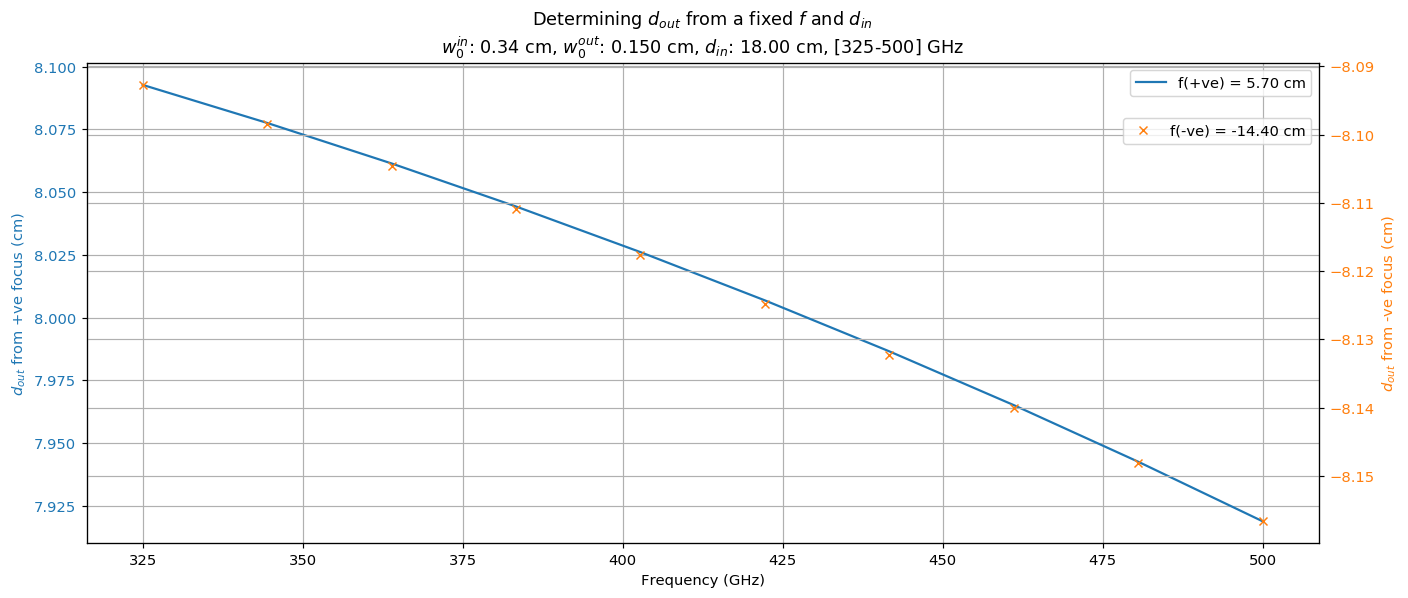

In [21]:
#%matplotlib widget
%matplotlib inline
start = f_case2()